# Bending of the lithosphere during subduction

**Goal:** Implement the solution to the 1D flexure equation that describes the bending of the subducting oceanic lithosphere and compare it's predictions against observations of gravity disturbances and bathymetry.



## The data

**Download** (if you haven't already): [global-geophysical-data.nc](https://github.com/leouieda/lithosphere/raw/main/data/global-geophysical-data.nc) (place it in the **same folder** as this notebook)

The data grids are stored in a [netCDF](https://en.wikipedia.org/wiki/NetCDF) file, which is a very common standard for storing and distributing gridded data. It's used throughout the Earth, ocean, and climate sciences and can be read an manipulated with most software platforms. It contains global grids of gravity, topography, and heat flow. All grids were interpolated onto the same resolution of 0.2 degrees (a compromise between resolution and size of the file) so that we can easily compare and use all of the data together.

* **Gravity**: generated from the [EIGEN-6C4 spherical harmonic model](https://doi.org/10.5880/icgem.2015.1) through the [ICGEM webservice](http://icgem.gfz-potsdam.de/home). It includes two grids: the gravity disturbance calculated with the WGS84 ellipsoid and the Bouguer gravity disturbance calculated using a topography density of 2670 kg/m³. The data for both grids was generated on top of the Earth's surface (the water surface in the oceans and topography on land).
* **Topography and bathymetry**: a downsampled version of [ETOPO1](https://doi.org/10.7289/V5C8276M) and includes a version smoothed using a Gaussian filter with 1 degree width (~100 km).
* **Heat flow**: an upsampled version of the compilation by [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389) (originally 0.5 degree resolution).
* **Lithosphere age (oceanic)**: a downsampled version of the grid by [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743) (originally 6 arc-minutes).

## Import the required libraries

Load the required software to load the data, make maps, and perform calculations.

In [1]:
# For arrays and linear algebra
import numpy as np
# To make figures and maps
import matplotlib.pyplot as plt
# To load and manipulate grids
import xarray as xr

## Load the data grids

Once again, we'll use xarray to load the data from the netCDF file.

In [2]:
data = xr.load_dataset("global-geophysical-data.nc")
data

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

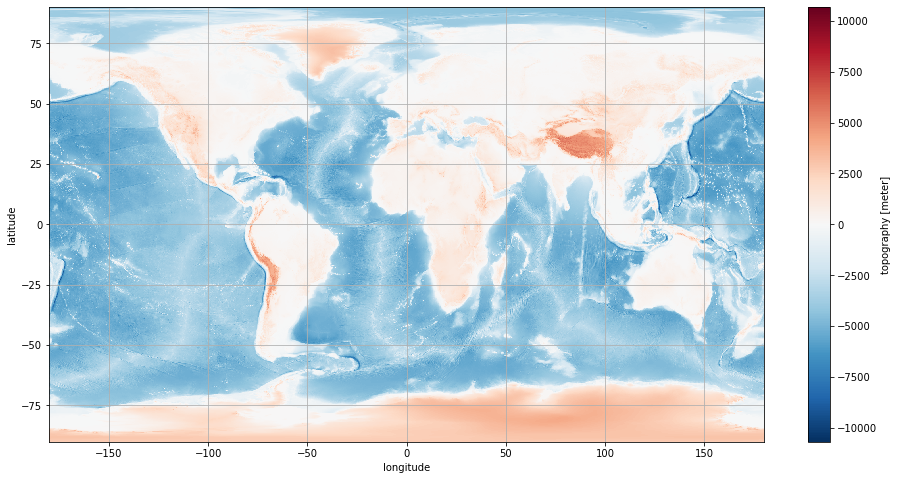

In [3]:
data.topography.plot(figsize=(16, 8))
plt.grid()

## Extracting a profile 


In [4]:
def profile_points(start, end, npoints):
    """
    Generate the evenly spaced points between start and end.
    The profile points follow a great circle.
    Returns the longitude and latitude coordinates of each point.
    """
    lon1, lat1 = np.radians(start)
    lon2, lat2 = np.radians(end)
    # These are needed to calculate the lon/lat coordinates of the profile.
    # See https://en.wikipedia.org/wiki/Great-circle_navigation#Finding_way-points
    azimuth1 = np.arctan2(
        np.cos(lat2) * np.sin(lon2 - lon1),
        np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
    )
    azimuth_equator = np.arctan2(
        np.sin(azimuth1) * np.cos(lat1),
        np.sqrt(np.cos(azimuth1) ** 2 + np.sin(azimuth1) ** 2 * np.sin(lat1) ** 2)
    )    
    great_circle_equator = np.arctan2(np.tan(lat1), np.cos(azimuth1))
    lon_equator = lon1 - np.arctan2(
        np.sin(azimuth_equator) * np.sin(great_circle_equator),
        np.cos(great_circle_equator)
    )
    # The great-circle distance between start and end (in radians)
    # This is the haversine formula: https://en.wikipedia.org/wiki/Haversine_formula
    great_circle_distance = 2 * np.arcsin(
        np.sqrt(
            np.sin((lat2 - lat1) / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2) ** 2
        )
    )
    # Generate evenly spaced points along the great circle 
    distances = np.linspace(start=0, stop=great_circle_distance, num=npoints)
    # Make the distances relative to where the great circle cross the equator
    # This is needed for the calculations below.
    distances_equator = distances + great_circle_equator 
    # Calculate the lon/lat coordinates of each point given their arc distance
    # and the azimuth of the great circle
    latitudes = np.arctan2(
        np.cos(azimuth_equator) * np.sin(distances_equator),
        np.sqrt(np.cos(distances_equator) ** 2 + (np.sin(azimuth_equator) * np.sin(distances_equator)) ** 2)
    )
    longitudes = lon_equator + np.arctan2(
        np.sin(azimuth_equator) * np.sin(distances_equator), 
        np.cos(distances_equator)
    )
    # Convert the arc-distances into kilometers
    mean_earth_radius = 6_371
    distances *= mean_earth_radius
    # xarray stuff so we can interpolate values on these coordinates
    # see: http://xarray.pydata.org/en/stable/interpolation.html#advanced-interpolation
    longitude = xr.DataArray(np.degrees(longitudes), coords={"distance": distances}, dims="distance")    
    latitude = xr.DataArray(np.degrees(latitudes), coords={"distance": distances}, dims="distance")
    return longitude, latitude

In [5]:
start = (140, 39)
end = (150, 28)

In [6]:
start = (140, 32)
end = (150, 33)

In [7]:
lon, lat = profile_points(start, end, npoints=100)

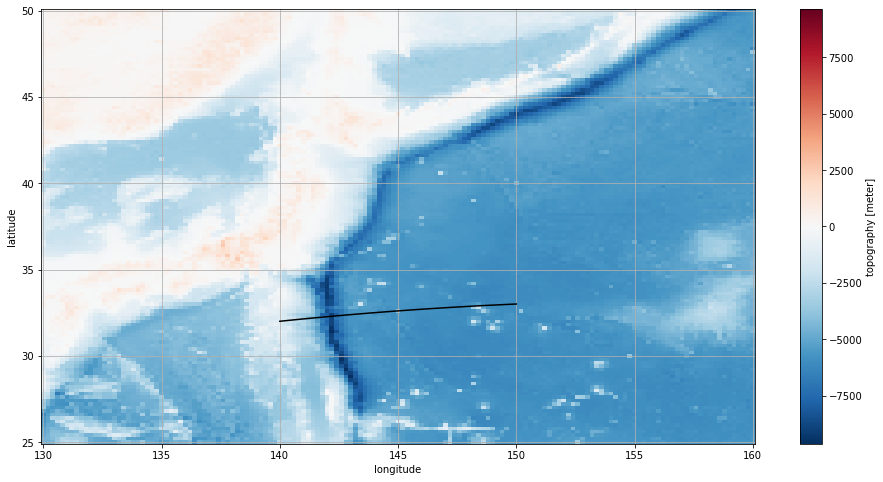

In [8]:
data.topography.sel(longitude=slice(130, 160), latitude=slice(25, 50)).plot(figsize=(16, 8))
plt.grid()
plt.plot(lon, lat, "k")

In [9]:
profile = data.interp(longitude=lon, latitude=lat)
profile

<xarray.Dataset>
Dimensions:              (distance: 100)
Coordinates:
    height               (distance) float64 41.61 41.08 40.57 ... 16.29 16.11
    longitude            (distance) float64 140.0 140.1 140.2 ... 149.9 150.0
    latitude             (distance) float64 32.0 32.01 32.03 ... 32.99 33.0
  * distance             (distance) float64 0.0 9.535 19.07 ... 934.5 944.0
Data variables:
    gravity_disturbance  (distance) float64 98.21 99.32 101.3 ... -6.416 -5.099
    gravity_bouguer      (distance) float64 180.3 197.9 215.8 ... 401.9 398.9
    topography_smoothed  (distance) float64 -2.201e+03 -2.283e+03 ... -5.876e+03
    topography           (distance) float64 -1.201e+03 -1.442e+03 ... -5.912e+03
    heat_flow            (distance) float64 141.4 133.6 122.3 ... 51.4 51.4 51.4
    lithosphere_age      (distance) float64 nan nan nan ... 145.1 145.2 145.2

In [10]:
profile = profile.isel(distance=profile.distance >= profile.distance[profile.topography.argmin()])

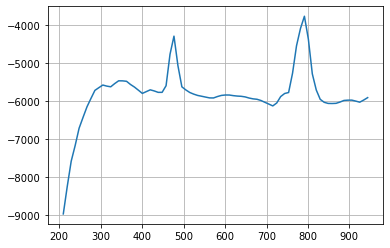

In [11]:
plt.plot(profile.distance, profile.topography)
plt.grid()

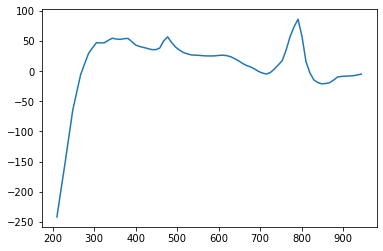

In [12]:
plt.plot(profile.distance, profile.gravity_disturbance)

In [13]:
def flexure_end_load(x, x0, xforebulge, flexure_forebulge):
    xscaled = (x - x0) / (xforebulge - x0)
    flexure = (
        flexure_forebulge
        * np.exp(np.pi / 4) 
        * np.sqrt(2) 
        * np.exp(- np.pi / 4 * xscaled)
        * np.sin(np.pi / 4 * xscaled)
    )
    return 1000 * flexure

In [14]:
base = -6000
flexure = flexure_end_load(
    profile.distance,
    x0=profile.distance[profile.topography > base].min(),
    xforebulge=340,
    flexure_forebulge=(-5500 - base) * 0.001,
)
predicted_bathymetry = base + flexure

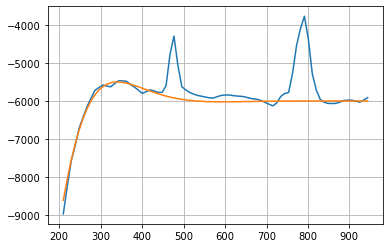

In [15]:
plt.plot(profile.distance, profile.topography)
plt.grid()
plt.plot(profile.distance, predicted_bathymetry)

In [16]:
import harmonica as hm

In [17]:
predicted_gravity = (
    hm.bouguer_correction(flexure, density_crust=(2800 - 1000), density_water=0)
    + hm.bouguer_correction(flexure, density_crust=(3300 - 2800), density_water=0)
)

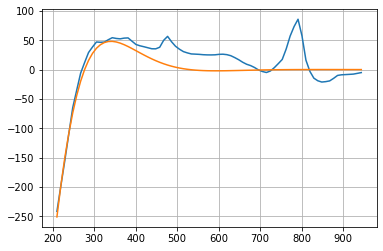

In [18]:
plt.plot(profile.distance, profile.gravity_disturbance)
plt.grid()
plt.plot(profile.distance, predicted_gravity)